# imports

In [4]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Read & Clean Dataset

In [12]:
data_df = pd.read_csv('Dataset/riceClassification.csv')
data_df.head()

,id,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,1,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,4,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,5,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [13]:
data_df.dropna(inplace=True) # remove empty rows
data_df.drop(['id'], axis=1, inplace=True)
data_df.shape

(18185, 11)

In [ ]:
data_df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [16]:
print(data_df['Class'].unique())
print(data_df['Class'].value_counts())

[1 0]
Class
1    9985
0    8200
Name: count, dtype: int64


In [17]:
original_df = data_df.copy()

# normalize the data
for col in data_df.columns:
    data_df[col] = data_df[col]/data_df[col].abs().max()

data_df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,0.444368,0.503404,0.775435,0.744658,0.424873,0.666610,0.741661,0.537029,0.844997,0.368316,1.0
1,0.281293,0.407681,0.622653,0.750489,0.273892,0.530370,0.804230,0.409661,0.919215,0.371471,1.0
2,0.298531,0.416421,0.630442,0.756341,0.284520,0.546380,0.856278,0.412994,0.959862,0.374747,1.0
3,0.300979,0.420463,0.629049,0.764024,0.286791,0.548616,0.883772,0.414262,0.961818,0.379222,1.0
4,0.361704,0.464626,0.682901,0.775033,0.345385,0.601418,0.867808,0.452954,0.966836,0.386007,1.0


# Data splitting

In [19]:
X = np.array(data_df.iloc[:,:-1]) # take all rows and all colums except the last one (class)
Y = np.array(data_df.iloc[:, -1]) # take all rows and the last colum (class)

In [20]:
# Training Size 80%
# Validation Size 10%
# Testing Size 10%

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5)

In [21]:
print(x_train.shape)
print(x_test.shape)
print(x_val.shape)

(14548, 10)
(1818, 10)
(1819, 10)


# Transfer data to pyTorch

In [24]:
class TorchDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.float32).to(device)
        self.Y = torch.tensor(Y, dtype=torch.float32).to(device)

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        return self.X[index], self.Y[index]

In [25]:
train_data = TorchDataset(x_train, y_train)
test_data = TorchDataset(x_test, y_test)
val_data = TorchDataset(x_val, y_val)

# Data Loader

In [81]:
BATCH_SIZE = 64
EPOCHS = 10
LR = 0.001

In [82]:
train_dataLoader = DataLoader(train_data, batch_size=8, shuffle=True)
test_dataLoader = DataLoader(test_data, batch_size=8, shuffle=True)
val_dataLoader = DataLoader(val_data, batch_size=8, shuffle=True)

# Model Class

In [83]:
class TorchModel(nn.Module):
    def __init__(self):
        super(TorchModel, self).__init__()
        
        self.input_layer = nn.Linear(X.shape[1], 10)
        self.linear = nn.Linear(10, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.input_layer(x)
        x = self.linear(x)
        x = self.sigmoid(x)
        return x

In [84]:
model = TorchModel().to(device)
summary(model, (X.shape[1], ))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]             110
            Linear-2                    [-1, 1]              11
           Sigmoid-3                    [-1, 1]               0
Total params: 121
Trainable params: 121
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


# Training

In [85]:
criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr=LR)

In [86]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []
# to see if model is overfitted or not

for epoch in range(EPOCHS):
    total_loss_train = 0
    total_loss_val = 0
    total_acc_train = 0
    total_acc_val = 0

    # train
    for data in train_dataLoader:
        inputs, lables = data
        pred = model(inputs).squeeze(1)
        batch_loss = criterion(pred, lables)
        total_loss_train += batch_loss.item()
        acc = ((pred).round() == lables).sum().item()
        total_acc_train += acc

        batch_loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    # vaildation
    with torch.no_grad():
        for data in val_dataLoader:
            inputs, labels = data
            pred = model(inputs).squeeze(1)
            batch_loss = criterion(pred, labels)
            total_loss_val += batch_loss.item()
            acc = ((pred).round() == labels).sum().item()
            total_acc_val += acc

    total_loss_train_plot.append(round(total_loss_train/1000, 4))
    total_loss_validation_plot.append(round(total_loss_val/1000, 4))
    total_acc_train_plot.append(round(total_acc_train/(train_data.__len__())*100, 4))
    total_acc_validation_plot.append(round(total_acc_val/(val_data.__len__())*100, 4))

    print(f'Epoch no. {epoch + 1} Train Loss: {total_loss_train/1000:.4f} Train Accuracy: {(total_acc_train/(train_data.__len__())*100):.4f} Validation Loss: {total_loss_val/1000:.4f} Validation Accuracy: {(total_acc_val/(val_data.__len__())*100):.4f}')
    print("="*50)

Epoch no. 1 Train Loss: 0.7926 Train Accuracy: 83.6679 Validation Loss: 0.0290 Validation Accuracy: 98.9005
Epoch no. 2 Train Loss: 0.1434 Train Accuracy: 98.4671 Validation Loss: 0.0113 Validation Accuracy: 98.6806
Epoch no. 3 Train Loss: 0.0908 Train Accuracy: 98.5840 Validation Loss: 0.0096 Validation Accuracy: 99.0104
Epoch no. 4 Train Loss: 0.0798 Train Accuracy: 98.5771 Validation Loss: 0.0086 Validation Accuracy: 98.6806
Epoch no. 5 Train Loss: 0.0771 Train Accuracy: 98.6115 Validation Loss: 0.0083 Validation Accuracy: 99.0654
Epoch no. 6 Train Loss: 0.0766 Train Accuracy: 98.5703 Validation Loss: 0.0088 Validation Accuracy: 99.0104
Epoch no. 7 Train Loss: 0.0760 Train Accuracy: 98.6459 Validation Loss: 0.0076 Validation Accuracy: 98.9555
Epoch no. 8 Train Loss: 0.0758 Train Accuracy: 98.5703 Validation Loss: 0.0073 Validation Accuracy: 98.9005
Epoch no. 9 Train Loss: 0.0750 Train Accuracy: 98.5565 Validation Loss: 0.0075 Validation Accuracy: 98.9555
Epoch no. 10 Train Loss: 0.0

# Testing

In [90]:
with torch.no_grad():
    total_loss_test = 0
    total_acc_test = 0

    for data in test_dataLoader:
        inputs, labels = data
        pred = model(inputs).squeeze(1)

        batch_loss_test = criterion(pred, labels)
        total_loss_test += batch_loss_test.item()
        acc = ((pred).round() == labels).sum().item()
        total_acc_test += acc

print(f"Accuracy Score is: {round((total_acc_test/x_test.shape[0])*100, 2)}%")   

Accuracy Score is: 98.4%


# Visualizations

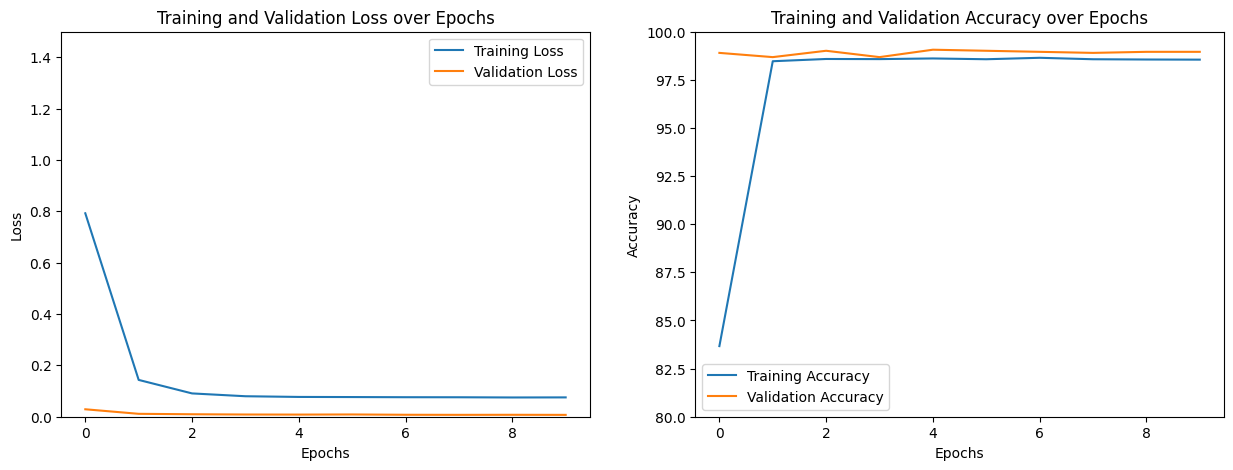

In [100]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].plot(total_loss_validation_plot, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].set_ylim([0, 1.5])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].plot(total_acc_validation_plot, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_ylim([80, 100])
axs[1].legend()

plt.show()

# Inference

In [117]:
# random sample
area = float(4137)/original_df['Area'].abs().max()
MajorAxisLength = float(78.698524)/original_df['MajorAxisLength'].abs().max()
MinorAxisLength = float(57.6521478)/original_df['MinorAxisLength'].abs().max()
Eccentricity = float(0.77458)/original_df['Eccentricity'].abs().max()
ConvexArea = float(4400)/original_df['ConvexArea'].abs().max()
EquivDiameter = float(60.2541785)/original_df['EquivDiameter'].abs().max()
Extent = float(0.7745896)/original_df['Extent'].abs().max()
Perimeter = float(225.65239)/original_df['Perimeter'].abs().max()
Roundness = float(0.9854127)/original_df['Roundness'].abs().max()
AspectRation = float(1.65238)/original_df['AspectRation'].abs().max()

In [118]:
my_inputs = [
    area, MajorAxisLength, MinorAxisLength, Eccentricity, ConvexArea,
    EquivDiameter, Extent, Perimeter, Roundness, AspectRation 
]

In [119]:
model_inputs = torch.Tensor(my_inputs).to(device)
prediction = (model(model_inputs))
print(prediction)
print("Class is: ", round(prediction.item()))

tensor([0.0875], device='cuda:0', grad_fn=<SigmoidBackward0>)
Class is:  0
